In [1]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\Code\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods

  Activating project at `C:\Users\KarlH\Desktop\ComputationalPhysicsMaster\Code\OrbitalNeuralMethods`
┌ Info: Precompiling OrbitalNeuralMethods [6de8678a-dd1c-461e-a987-24da1d9562b4]
└ @ Base loading.jl:1423


In [19]:
using PyFormattedStrings
import Plots as plt

## HO Basis and Spatial System

In [3]:
exact = 0.8247

0.8247

In [49]:
l = 10
ω = 0.25
basis = SpinBasis(HOBasis(l, ω))

n = 2
V = ShieldedCoulomb(0.25)
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, V);
println(f"HO Basis Ref : E = {reference_energy(system):.4f}, D = {reference_energy(system) - exact:.4f}")

HO Basis Ref : E = 1.3837, D = 0.5590


## HF

In [5]:
hf = setup_HF(system);
compute_ground_state!(hf, max_iter = 1000, tol = 1e-10)
println(f"HF  : E = {energy(hf):.4f}, D = {energy(hf) - exact:.4f}")

rhf = setup_RHF(system);
compute_ground_state!(rhf, max_iter = 1000, tol = 1e-10)
println(f"RHF : E = {energy(rhf):.4f}, D = {energy(rhf) - exact:.4f}")

HF  : E = 0.8450, D = 0.0203
RHF : E = 1.1796, D = 0.3549


In [6]:
println(hf.C[:,1][1:4])
println(hf.C[:,2][1:4])
println("These are not spin-anti-symmetric")

[0.0016773063019815638, 0.9654195818131047, 0.00024962996138401907, -4.3370355778482606e-7]
[0.0003097512203896981, -5.381573829293698e-7, 0.001726257006134819, 0.9935945002984495]
These are not spin-anti-symmetric


## CCD

In [7]:
ccd = setup_CCD(system);
compute_ground_state!(ccd, max_iter = 1000, tol = 1e-10)
println(f"CCD    : E = {energy(ccd):.4f}, D = {energy(ccd) - exact:.4f}")

ccd = setup_CCD(System(rhf));
compute_ground_state!(ccd, max_iter = 1000, tol = 1e-10)
println(f"CCD+RHF: E = {energy(ccd):.4f}, D = {energy(ccd) - exact:.4f}")

ccd = setup_CCD(System(hf));
compute_ground_state!(ccd, max_iter = 1000, tol = 1e-10)
println(f"CCD+HF : E = {energy(ccd):.4f}, D = {energy(ccd) - exact:.4f}")

CCD    : E = 1.0517, D = 0.2270
CCD+RHF: E = 0.8384, D = 0.0137
CCD+HF : E = 0.8377, D = 0.0130


## CCSD

In [8]:
ccsd = setup_CCSD(system);
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD    : E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

ccsd = setup_CCSD(System(rhf));
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD+RHF: E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

ccsd = setup_CCSD(System(hf));
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD+HF : E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

CCSD    : E = 0.8253, D = 0.0006
CCSD+RHF: E = 0.8253, D = 0.0006
CCSD+HF : E = 0.8374, D = 0.0127


In [9]:
big_system = System(n, SpinBasis(HOBasis(20, ω)), grid, V);

ccsd = setup_CCSD(big_system);
compute_ground_state!(ccsd, max_iter = 1000, tol = 1e-10)
println(f"CCSD    : E = {energy(ccsd):.4f}, D = {energy(ccsd) - exact:.4f}")

CCSD    : E = 0.8250, D = 0.0003


## Convergence Acceleration

In [10]:
function how_fast(state; max_iter, tol)
    iters = 1
    old_E = energy(state)

    for i in 1:max_iter
        update!(state)

        new_E = energy(state)
        if abs(new_E - old_E) < tol
            return iters
        end
        old_E = new_E
        iters += 1
    end
    return max_iter
end

how_fast (generic function with 1 method)

In [22]:
alphas = 0:0.01:1
max_iter = 300

needed_iters_ccd = zero(alphas)
needed_iters_ccsd = zero(alphas)

for (i, alpha) in enumerate(alphas)
    ccd = setup_CCD(System(rhf), Alpha(alpha))
    needed_iters_ccd[i] = how_fast(ccd, max_iter = max_iter, tol = 1e-10)
    
    ccsd = setup_CCSD(System(rhf), Alpha(alpha))
    needed_iters_ccsd[i] = how_fast(ccsd, max_iter = max_iter, tol = 1e-10)
end

CCD min: α = 0.65 iters = 39.0
CCSD min: α = 0.61 iters = 55.0


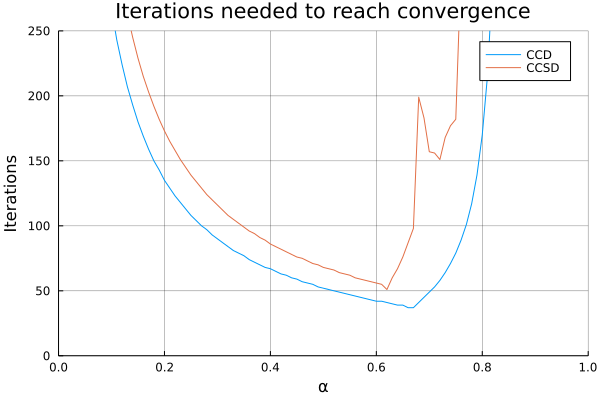

In [23]:
ccd_min = argmin(needed_iters_ccd[2:end])
ccsd_min = argmin(needed_iters_ccsd[2:end])
println("CCD min: α = $(alphas[ccd_min]) iters = $(needed_iters_ccd[ccd_min])")
println("CCSD min: α = $(alphas[ccsd_min]) iters = $(needed_iters_ccsd[ccsd_min])")

plt.plot(yrange = (0, 250), xrange=(0,1), gridalpha=0.5, xlabel="α", ylabel="Iterations", title="Iterations needed to reach convergence")
plt.plot!(alphas[2:end], needed_iters_ccd[2:end], label="CCD")
plt.plot!(alphas[2:end], needed_iters_ccsd[2:end], label="CCSD")
plt.savefig("alpha_iters.png")
plt.plot!()

## Energy/Iter

In [14]:
ccsd = setup_CCSD(System(rhf));
println(how_fast(ccsd, max_iter=100, tol=1e-10))
ccd = setup_CCD(System(rhf));
println(how_fast(ccd, max_iter=100, tol=1e-10))

17
15


In [30]:
ccsd_alpha = setup_CCSD(System(rhf), Alpha(0.61));
ccd_alpha = setup_CCD(System(rhf), Alpha(0.65));
ccsd = setup_CCSD(System(rhf));
ccd = setup_CCD(System(rhf));

iters = 20
ccd_energies = zeros(iters+1)
ccsd_energies = zeros(iters+1)
ccd_alpha_energies = zeros(iters+1)
ccsd_alpha_energies = zeros(iters+1)

ccd_energies[1] = energy(ccd)
ccsd_energies[1] = energy(ccsd)
ccd_alpha_energies[1] = energy(ccd_alpha)
ccsd_alpha_energies[1] = energy(ccsd_alpha)
for i in 2:iters+1
    update!(ccd)
    update!(ccsd)
    update!(ccd_alpha)
    update!(ccsd_alpha)
    ccd_energies[i] = energy(ccd)
    ccsd_energies[i] = energy(ccsd)
    ccd_alpha_energies[i] = energy(ccd_alpha)
    ccsd_alpha_energies[i] = energy(ccsd_alpha)
end

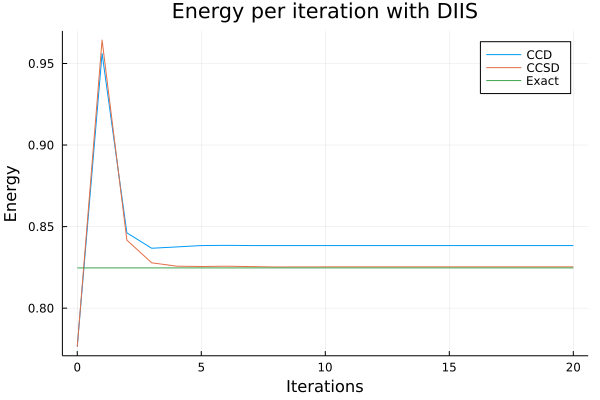

In [35]:
plt.plot(xlabel="Iterations", ylabel="Energy", title="Energy per iteration with DIIS")
plt.plot!(0:iters, ccd_energies, label="CCD")
plt.plot!(0:iters, ccsd_energies, label="CCSD")
plt.plot!([0, 20], [exact, exact], label="Exact")
plt.savefig("diis_conv.png")
plt.plot!()

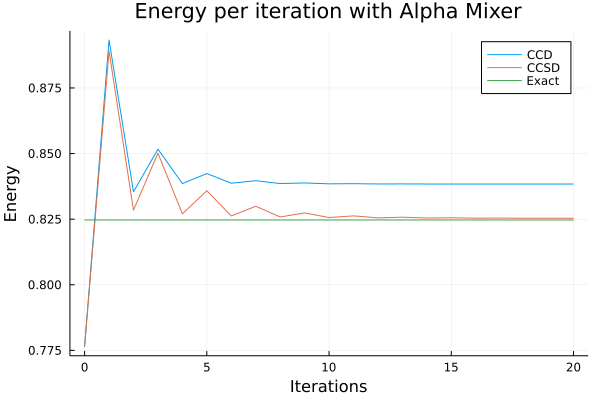

In [34]:
plt.plot(xlabel="Iterations", ylabel="Energy", title="Energy per iteration with Alpha Mixer")
plt.plot!(0:iters, ccd_alpha_energies, label="CCD")
plt.plot!(0:iters, ccsd_alpha_energies, label="CCSD")
plt.plot!([0, 20], [exact, exact], label="Exact")
plt.savefig("alpha_conv.png")
plt.plot!()

## Particle Density

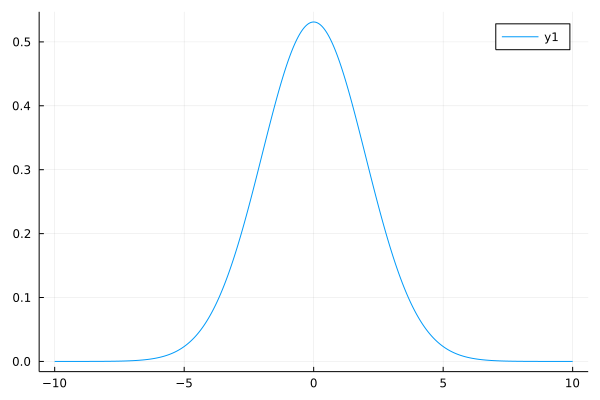

In [50]:
plt.plot(grid, system.spfs[1])

In [59]:
scale = 20/2001
sum(system.spfs[1].^2 * scale)

0.9995002498735648

In [125]:
phis = System(hf).spfs;
rho = phis[1].^2 .+ phis[2].^2

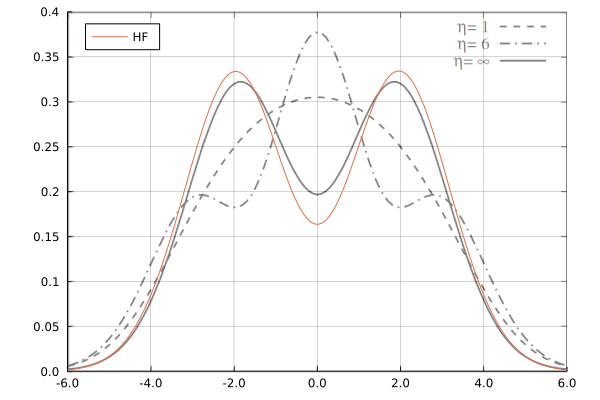

In [129]:
x_trans, y_trans = imgplot(file     = "GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )
plt.plot!(legend=:topleft)
plt.plot!(x_trans.(grid), y_trans.(phis[1].^2 .+ phis[2].^2), label="HF")

In [123]:
import FileIO
import ColorVectorSpace
function imgplot(;file, extent, imgalpha, xticks, yticks)
    img = FileIO.load(file) .- ColorVectorSpace.RGBA(0, 0, 0, 1 - imgalpha)
    
    h, w = size(img)
    x0, x1, y0, y1 = extent
    dx = x1 - x0
    x_mid = (x0 + x1) / 2
    dy = y1 - y0
    
    plt.plot(img,
             xlim = (0, w),
             ylim = (0, h),
             yticks = h .- (yticks .- y0) .* h ./ dy,
             xticks = (xticks .+ dx ./ 2) .* w ./ dx,
             grid = true, gridalpha = 0.7,
             size = (600, 400),
             xformatter = x -> round((x / w - 0.5 + x_mid/dx) * dx, digits = 1),
             yformatter = y -> round((-y / h * dy + y0 + dy), digits = 10),
             )
    return x -> (x - x_mid + dx/2) * w / dx, y -> h - (y - y0) * h / dy
end

imgplot (generic function with 1 method)